# Transformer

Implementation and testing of a real Transformer, as described in the original paper ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762).

![Transformer](img/transformer.png)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import seaborn as sns
import matplotlib.pyplot as plt
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show
from nltk.tokenize import word_tokenize
import spacy

C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


# Transformers

Task is translation from English to Italian

In [ ]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download it_core_news_lg

In [3]:
max_sequence_len = 60 #number of tokens in each sentence
d_model = 6 #dimension of embeddings

In [7]:
START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

#loading vocabulary through spacy
nlp_en = spacy.load('en_core_web_lg')
nlp_it = spacy.load('it_core_news_lg')
italian_vocab = [START_TOKEN, PADDING_TOKEN] + list(nlp_it.vocab.strings) + [END_TOKEN]
english_vocab = [START_TOKEN, PADDING_TOKEN] + list(nlp_en.vocab.strings) + [END_TOKEN]

#lookup tables
index_to_italian = {k:v for k,v in enumerate(italian_vocab)}
italian_to_index = {v:k for k,v in enumerate(italian_vocab)}
index_to_english = {k:v for k,v in enumerate(english_vocab)}
english_to_index = {v:k for k,v in enumerate(english_vocab)}

In [8]:
# We start by Embedding vocabularies

english_embedding = nn.Embedding(len(english_vocab), d_model)
italian_embedding = nn.Embedding(len(italian_vocab), d_model)

en_w, it_w = 660403, 559485
print(f"Embedding for the word {index_to_english[en_w]}: {english_embedding(torch.tensor(en_w))}")
print(f"Embedding for the word {index_to_italian[it_w]}: {italian_embedding(torch.tensor(it_w))}")

Embedding for the word subterranean: tensor([-1.1369, -0.8225,  0.2595, -0.6104,  1.1484, -0.3768],
       grad_fn=<EmbeddingBackward0>)
Embedding for the word proclamasse: tensor([ 0.7371, -1.4045,  0.0519,  0.8513,  0.5025,  1.0786],
       grad_fn=<EmbeddingBackward0>)


In [9]:
#utility functions for checking sentence validity
def is_valid_tokens(sentence_tokenized, vocab):
    for token in sentence_tokenized:
        if isinstance(token, str):
            w = token
        else:
            w = token.text
        if w not in vocab:
            return False
    return True

def is_valid_length(sentence_tokenized, max_sequence_length):
    return len(sentence_tokenized) < (max_sequence_length)

def filter_and_preprocess(sent, tokenizer, vocab, max_s_len):
    tokenized = tokenizer(sent)
    if is_valid_length(tokenized, max_s_len) and is_valid_tokens(tokenized, vocab):
        return str(sent)
    return False

In [10]:
#taking only the first 10000 sentences meeting the requirements
MAX_SENTENCES = 10000

In [12]:
it_tokenizer = lambda text: word_tokenize(text, language='italian')
en_tokenizer = lambda text: word_tokenize(text, language='english')

In [13]:
english_file = "./data/it-en/europarl-v7.it-en.en"
italian_file = "./data/it-en/europarl-v7.it-en.it"

en_vocab = set(english_vocab)
it_vocab = set(italian_vocab)

#loading corpus for training
count = 0
english_lines, italian_lines = [], []
english_sentences, italian_sentences = [], []

print('Reading english sentences...')
with open(english_file,'rt') as f:
    english_lines = f.readlines()

print('Reading italian sentences...')
with open(italian_file,'rt') as f:
    italian_lines = f.readlines()

for (sentence_en, sentence_it) in zip(english_lines, italian_lines):
    if count < MAX_SENTENCES:
        preprocessed_sent_en = filter_and_preprocess(sentence_en.lower()[:-1],
                                                    en_tokenizer,
                                                    en_vocab,
                                                    max_sequence_len)
        if preprocessed_sent_en:
            preprocessed_sent_it = filter_and_preprocess(sentence_it.lower()[:-1],
                                                it_tokenizer,
                                                it_vocab,
                                                max_sequence_len)
            if preprocessed_sent_it:
                english_sentences.append(preprocessed_sent_en)
                italian_sentences.append(preprocessed_sent_it)
                count += 1
                print(count, end='\r')
    else: break

Reading english sentences...
Reading italian sentences...


In [14]:
#we build a dataset class for our specific MT task
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, italian_sentences):
        self.english_sentences = english_sentences
        self.italian_sentences = italian_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.italian_sentences[idx]

In [16]:
#here is our dataset instance, which will work flawlessly with other pytorch modules
dataset = TextDataset(english_sentences, italian_sentences)

#saving the dataset
torch.save(dataset, './data/it-en/dataset.pt')

In [17]:
dataset = torch.load('./data/it-en/dataset.pt', weights_only=False)

In [18]:
#we can also batch our data to make training faster
batch_size = 3
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)
batch = next(iterator)

for i in range(batch_size):
    print(f"English: {batch[0][i]}")
    print(f"Italian: {batch[1][i]}\n\n")

English: resumption of the session
Italian: ripresa della sessione


English: i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Italian: dichiaro ripresa la sessione del parlamento europeo, interrotta venerdì 17 dicembre e rinnovo a tutti i miei migliori auguri nella speranza che abbiate trascorso delle buone vacanze.


English: please rise, then, for this minute' s silence.
Italian: vi invito pertanto ad alzarvi in piedi per osservare appunto un minuto di silenzio.




In [19]:
def tokenize(sentence, language_to_index, lang_tokenizer, start_token=True, end_token=True):
    sentence_word_ids = [language_to_index[token.text] for token in lang_tokenizer(sentence)]
    if start_token:
        sentence_word_ids.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_ids.append(language_to_index[END_TOKEN])
    for _ in range(len(sentence_word_ids), max_sequence_len):
        sentence_word_ids.append(language_to_index[PADDING_TOKEN])
    return torch.tensor(sentence_word_ids)

In [21]:
eng_tokenized, it_tokenized = [], []
for sentence_num in range(batch_size):
    eng_sentence, it_sentence = batch[0][sentence_num], batch[1][sentence_num]
    eng_tokenized.append(tokenize(eng_sentence, english_to_index, nlp_en.tokenizer, start_token=False, end_token=True))
    #start and end tokens are required for beginning and ending in the generation phase
    it_tokenized.append(tokenize(it_sentence, italian_to_index, nlp_it.tokenizer, start_token=True, end_token=True))
eng_tokenized = torch.stack(eng_tokenized)
it_tokenized = torch.stack(it_tokenized)

In [22]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, lang_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.language_tokenizer = lang_tokenizer
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token=True, end_token=True):

        def tokenize(sentence, start_token=True, end_token=True):
            sentence_word_ids = [self.language_to_index[token.text] for token in self.language_tokenizer(sentence)]
            if start_token:
                sentence_word_ids.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_ids.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_ids), self.max_sequence_length):
                sentence_word_ids.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_ids)

        tokenized = []
        for sentence_num in range(len(batch)):
            tokenized.append(tokenize(batch[sentence_num], start_token, end_token))
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token = True, end_token=True): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        return x

In [24]:
sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index,
                                    nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
english_batch = next(iterator)[0]
print(f"Input batch: {english_batch}\nOutput embeddings shapes:{[embedding.size() for embedding in sentence_embedding(english_batch, start_token = False, end_token = True)]}\nOuput embeddings: {sentence_embedding(english_batch)}")

Input batch: ('if the house agrees, i shall do as mr evans has suggested.', 'madam president, on a point of order.', 'that is precisely the time when you may, if you wish, raise this question, i.e. on thursday prior to the start of the presentation of the report.')
Output embeddings shapes:[torch.Size([60, 6]), torch.Size([60, 6]), torch.Size([60, 6])]
Ouput embeddings: tensor([[[ 0.3675, -0.8975,  0.3463, -2.0727,  3.2634, -1.4360],
         [-1.0836, -1.0870,  0.0671,  1.0532,  1.0600, -0.2162],
         [ 0.2984, -0.5531, -0.1360, -2.2460,  0.1558, -0.2555],
         ...,
         [ 0.9139, -0.2925,  0.2005, -0.8675, -1.3621, -1.0680],
         [ 0.9139, -0.2925,  0.2005, -0.8675, -1.3621, -1.0680],
         [ 0.9139, -0.2925,  0.2005, -0.8675, -1.3621, -1.0680]],

        [[ 0.3675, -0.8975,  0.3463, -2.0727,  3.2634, -1.4360],
         [-0.6444, -0.4359,  0.6983, -0.8250, -0.2256, -0.8024],
         [ 2.5103, -0.9142, -0.8219, -1.0749, -1.4161,  0.5036],
         ...,
         [ 0

### Positional Encoding

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        i = torch.arange(0,self.d_model,2, dtype=torch.float).repeat_interleave(2)[:self.d_model]
        denominator = torch.pow(10000, 2*i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        sin_cos_argument = position/denominator
        PE = torch.zeros(size = sin_cos_argument.shape)
        PE[:, 0::2] = torch.sin(sin_cos_argument[:, 0::2])
        PE[:, 1::2] = torch.cos(sin_cos_argument[:, 1::2])
        return PE

In [26]:
# Updated version that applies Positional Encoding

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, lang_tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.language_tokenizer = lang_tokenizer
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token=True, end_token=True):

        def tokenize(sentence, start_token=True, end_token=True):
            sentence_word_ids = [self.language_to_index[token.text] for token in self.language_tokenizer(sentence)]
            if start_token:
                sentence_word_ids.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_ids.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_ids), self.max_sequence_length):
                sentence_word_ids.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_ids)

        tokenized = []
        for sentence_num in range(len(batch)):
            tokenized.append(tokenize(batch[sentence_num], start_token, end_token))
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token = True, end_token=True): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x

In [27]:
sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index, nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
english_batch = next(iterator)[0]
print(f"Input batch: {english_batch}\nOutput embeddings shapes:{[embedding.size() for embedding in sentence_embedding(english_batch, start_token = False, end_token = True)]}\nOuput embeddings: {sentence_embedding(english_batch)}")


Input batch: ('this is all in accordance with the principles that we have always upheld.', 'thank you, mr segni, i shall do so gladly.', 'indeed, it is quite in keeping with the positions this house has always adopted.')
Output embeddings shapes:[torch.Size([60, 6]), torch.Size([60, 6]), torch.Size([60, 6])]
Ouput embeddings: tensor([[[-1.0373,  1.4222,  2.5010, -0.0125, -0.3151,  1.9529],
         [ 1.2329,  2.9701,  0.7490,  0.9989, -0.1949,  0.3348],
         [ 1.4299, -0.1342, -1.6556, -0.1295, -0.7283, -0.0000],
         ...,
         [-0.0596,  1.7782, -2.0996,  0.5660,  0.1022, -0.2296],
         [ 0.5590,  0.9108, -2.0972,  0.0000,  0.1022, -0.2296],
         [ 0.1633, -0.0784, -2.0948,  0.5654,  0.1022, -0.2296]],

        [[-1.0373,  0.0000,  2.5010, -0.0125, -0.0000,  1.9529],
         [ 1.6844,  1.7038,  0.0170,  0.5490,  0.7930,  3.5124],
         [ 2.0315,  0.0746, -0.1691,  1.7907, -0.2260,  0.3195],
         ...,
         [-0.0596,  1.7782, -2.0996,  0.0000,  0.1022, -0

In [28]:
en_sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, english_to_index, nlp_en.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)
it_sentence_embedding = SentenceEmbedding(max_sequence_len, d_model, italian_to_index, nlp_it.tokenizer, START_TOKEN, END_TOKEN, PADDING_TOKEN)

In [29]:
english_batch, italian_batch = next(iterator)

In [30]:
np.set_printoptions(suppress=True)
x = torch.tensor(np.random.randint(1, 6, size=(4, 3)), dtype=float)
print(x, "\n")
print(x.T @ x, "\n")
print(torch.nn.functional.softmax(x.T @ x, dim=0).detach().numpy(), "\n")
print((torch.nn.functional.softmax(x.T @ x, dim=0) @ x.T).detach().numpy())

tensor([[3., 5., 5.],
        [2., 3., 2.],
        [2., 4., 4.],
        [4., 5., 4.]], dtype=torch.float64) 

tensor([[33., 49., 43.],
        [49., 75., 67.],
        [43., 67., 61.]], dtype=torch.float64) 

[[0.00000011 0.         0.        ]
 [0.99752726 0.99966465 0.99752738]
 [0.00247262 0.00033535 0.00247262]] 

[[ 0.00000034  0.00000022  0.00000022  0.00000045]
 [12.97854193  6.98910323  9.98382264 12.97854182]
 [ 0.02145774  0.01089654  0.01617714  0.02145773]]


### Attention

In [31]:
d_k, d_v =  d_model, d_model
w_q = torch.randn(d_k, d_k)
w_k = torch.randn(d_k, d_k)
w_v = torch.randn(d_v, d_v)
input = en_sentence_embedding(english_batch, start_token = False, end_token = True)[0] #embeddings
tokenized_sentence = en_sentence_embedding.batch_tokenize(english_batch, start_token = False, end_token = True)[0] #textual representation of sentence, tokenized
tokenized_sentence_pad = [index_to_english[t.item()] for t in tokenized_sentence]
tokenized_sentence_nopad = [index_to_english[t.item()] for t in tokenized_sentence if t != english_to_index[PADDING_TOKEN]]
print(f"Query weight matrix shape:\t{w_q.size()}")
print(f"Key weight matrix shape:\t{w_k.size()}")
print(f"Value weight matrix shape:\t{w_v.size()}")
print(f"Input matrix shape:\t\t{input.size()}")

#computing Q, K and V
q = torch.matmul(input, w_q)
k = torch.matmul(input, w_k)
v = torch.matmul(input, w_v)
print(f"Query matrix shape:\t\t{q.size()}")
print(f"Key matrix shape:\t\t{k.size()}")
print(f"Value matrix shape:\t\t{v.size()}")

Query weight matrix shape:	torch.Size([6, 6])
Key weight matrix shape:	torch.Size([6, 6])
Value weight matrix shape:	torch.Size([6, 6])
Input matrix shape:		torch.Size([60, 6])
Query matrix shape:		torch.Size([60, 6])
Key matrix shape:		torch.Size([60, 6])
Value matrix shape:		torch.Size([60, 6])


In [32]:
input_img, q_img, k_img, v_img = input[:len(tokenized_sentence_nopad),:] ,q[:len(tokenized_sentence_nopad),:], k[:len(tokenized_sentence_nopad),:], v[:len(tokenized_sentence_nopad),:]


In [33]:
def softmax(x):
  return (torch.exp(x).T / torch.sum(torch.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v):
  d_k = q.shape[-1]
  scaled = torch.matmul(q, k.T) / math.sqrt(d_k)
  attention = softmax(scaled)
  output = torch.matmul(attention, v)
  return output, attention

In [34]:
o, att = scaled_dot_product_attention(q, k, v)
print(f"Output shape:\t\t{o.size()}")
print(f"Attention shape:\t{att.size()}")

Output shape:		torch.Size([60, 6])
Attention shape:	torch.Size([60, 60])


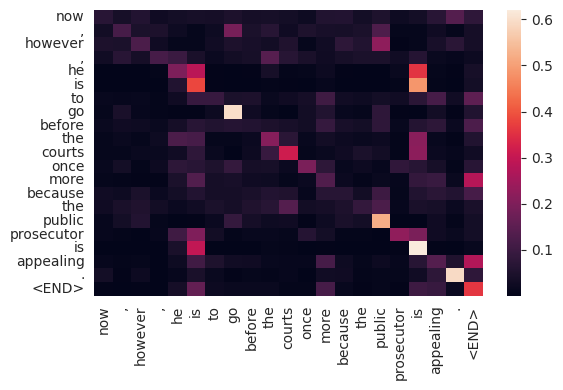

In [35]:
o, att = scaled_dot_product_attention(input_img, input_img, v_img)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(att.detach().numpy(), xticklabels=tokenized_sentence_nopad, yticklabels=tokenized_sentence_nopad, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
#quick visualization
sentence_a = "John loves Mary"
sentence_b = "She is happy for that"
model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=4, head=3)